# Visualizing the Pix2Pix results

Let's visualize some random results from the Pix2Pix model. To do so we just need to load a generator model and feed it with a "source image". Here you will need to provide an image that is compatible with the source you trained on. We will test two of the pre-trained models we provide you with. One transforming face landmarks into Rembrandt paintings, and one transforming face edges into comics drawings. First let's see how to do this in a notebook: 

## Visualizing the results in a notebook

### Landmarks to Rembrant

First let's load the generator. You need to watch out for two variables here:
- `model_path`
- `epoch`

The first variable, `model_path` defines the directory where you saved your models.

The second, `epoch` defines the epoch for which you want to load a model. You can examine the directory and the example images for each epoch, to choose which epoch you want to visualize.

To test this you can download a pre-trained model for the 100th epoch here: 
https://enist.org/dmlap_models/landmarks2rembrandt.zip
Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.


In [39]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os 

model_path = './models/landmarks2rembrandt'
epoch = 100

generator = keras.models.load_model(os.path.join(model_path, f'e{epoch}_generator.hd5'))

def transform_image(img):
    img = (img - 127.5)/127.5
    result = generator(np.expand_dims(img, 0), training=True)[0]
    return result * 0.5 + 0.5
    

Now let's load a face image (Spock) find the face landmarks, draw them and then apply the model. We will first define a function that uses the [Canvas API](https://github.com/colormotor/py5canvas) to create the face landmarks and draw them into an image

In [40]:
def apply_face_landmarks(img, stroke_weight=3):
    from py5canvas import canvas
    from mlxtend.image import extract_face_landmarks

    def landmark_polylines(landmarks):
        # https://pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/
        landmarks = np.array(landmarks).astype(np.float32)
        indices = [list(range(0, 17)),
                list(range(17, 22)),
                list(range(22, 27)),
                list(range(27, 31)),
                list(range(31, 36)),
                list(range(36, 42)) + [36],
                list(range(42, 48)) + [42],
                list(range(48, 60)) + [48],
                list(range(60, 68)) + [60]]
        return [landmarks[I] for I in indices]

    c = canvas.Canvas(256, 256)
    c.background(0)
    landmarks = extract_face_landmarks(img)
    if landmarks is None:
        return None
    c.stroke_weight(stroke_weight)
    c.no_fill()
    c.stroke(255)
    paths = landmark_polylines(landmarks)
    for path in paths:
        c.polyline(path)
    return c.get_image()

Then we will load an image (make sure it is 256x256 pixels in size) and use the generator model we loaded to apply the model to the face landmarks

255


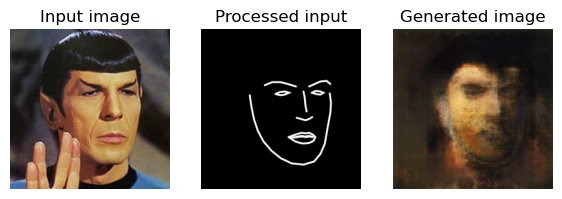

In [41]:
from skimage import io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img = io.imread('images/spock256.jpg')
landmark_img = apply_face_landmarks(img)

plt.figure(figsize=(7,4))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed input')
plt.imshow(landmark_img)
plt.axis('off')
print(np.max(landmark_img))
plt.subplot(1, 3, 3)
gen_img = transform_image(landmark_img)
plt.title('Generated image')
plt.imshow(gen_img)
plt.axis('off')
plt.show()

Note that we need to scale the input to the generator from the [0,255] range to the [-1,1] range.

### Edges to comics
Now let's try a similar procedure with the Edge to comics. 
Again, to test this you can download a pre-trained model for the 50th epoch here: 
https://enist.org/dmlap_models/edges2comics.zip
Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.

Now let's load the model

In [42]:

model_path = './models/edges2comics'
epoch = 50

generator = keras.models.load_model(os.path.join(model_path, f'e{epoch}_generator.hd5'))

def transform_image(img):
    img = (img - 127.5)/127.5
    result = generator(np.expand_dims(img, 0), training=True)[0]
    return result * 0.5 + 0.5

This time we create a function that takes our input and applies edge detection to it

In [43]:
def apply_canny_skimage(img, sigma=1.5):
    import cv2
    from skimage import feature
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

And again apply a similar procecss to transform our input

255


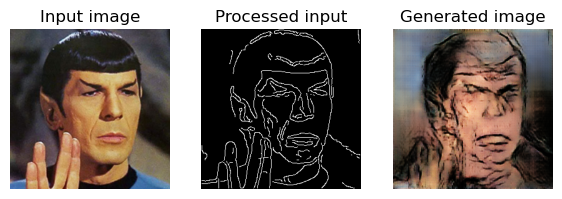

In [44]:
from skimage import io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img = io.imread('images/spock256.jpg')
edges_img = apply_canny_skimage(img)

plt.figure(figsize=(7,4))
plt.subplot(1, 3, 1)
plt.title('Input image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed input')
plt.imshow(edges_img)
plt.axis('off')
print(np.max(landmark_img))
plt.subplot(1, 3, 3)
gen_img = transform_image(edges_img)
plt.title('Generated image')
plt.imshow(gen_img)
plt.axis('off')
plt.show()

## Interactive viewing

To interactively view the pix2pix results you will need to install [Py5Canvas](https://github.com/colormotor/py5canvas) (follow the instructions in the repository) or, if it is installed, update it to the latest version by navigating to the `py5canvas` directory in the terminal and then pulling with `git pull`. 

Then copy the `pix2pix_draw.py`, `pix2pix_edges.py` and `pix2pix_face_landmarks.py` scripts provided in the `py5sketches` directory of the DMLAP repository to your preferred location (e.g. your project directory) and open a terminal. Preferably, put the scripts into a subdirectory so the paths in the scripts are consistent with your personal directory layout. 

- The first script `pix2pix_draw.py` let's you draw scribbles that are then transformed by the given model, when pressing the spacebar. To clear the drawing press "c".
- The second script `pix2pix_edges.py` performs edge detection on the webcam input and then uses the specified model to transform the edges.
- The third script `pix2pix_face_landmarks.py` finds and draws face landmarks from the webcam input and then uses the specified model to transform the landmarks. If not landmarks are found the script will simply visualize the webcam input.


To run, open a terminal and use `cd` to navigate to the directory where you placed
 the scripts and then activate your conda environment (e.g. with `conda activate dmlap` if that is what you called the environment). Finally run the script. For example to run `pix2pix_draw.py`
 ```
 py5sketch pix2pix_draw.py
 ``` 
In the `pix2pix_draw.py` script (or the one you choose to run) you can modify the variable `model_path` so it points to the `hd5` file for the model you want to test.